### ResNet50 -> transfer learning ( 모든 layer 학습)

In [1]:
import tensorflow as tf

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9559597267481589739,
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17833491943710941742
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9703141108631690919
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:2"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16761447136650286221
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:3"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13668389271257000368
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14583492292951907966
 physical_device_desc: "device: XLA_CPU device"

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Input, Activation,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,LambdaCallback
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [49]:
# fc layer 제외 (ImageNet pretrained)
input = Input(shape=(224, 224, 3))
model = ResNet50(input_tensor=input, include_top=False, weights="imagenet", pooling='max')
print(model.summary())


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [50]:
x = model.output
print(x.shape)
x = Dense(1024, name='fully')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 고양이 or 개
x = Dense(2, activation='softmax', name='softmax')(x)

model_1 = Model(model.input, x)
# model.summary()
train_datagen = ImageDataGenerator(rescale=1./255)#rgb값 reduce
train_generator = train_datagen.flow_from_directory(
        './data/vgg16_dataset/train_new',
        target_size=(224, 224),
        batch_size=30,
        class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        './data/vgg16_dataset/validation',
        target_size=(224, 224),
        batch_size=30,
        class_mode='categorical')
model_1.summary()

(?, 2048)
Found 23620 images belonging to 2 classes.
Found 4730 images belonging to 2 classes.
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                    

In [51]:
with tf.device('/gpu:0'):    
    model_1.compile(loss='categorical_crossentropy',
                      #optimizer=optimizers.RMSprop(lr=2e-4),
                      optimizer=Adam(),
                      metrics=['acc'])

#     print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: None)
    early_stopping = EarlyStopping(patience=15, mode='min', monitor='val_loss')
    history = model_1.fit_generator(train_generator,
                                  steps_per_epoch=10,
                                  epochs=100,
                                  validation_data=val_generator,
                                  validation_steps=5,
                                  callbacks=[early_stopping])

    #모델 평가
    print("-- Evaluate --")
    scores = model_1.evaluate_generator(val_generator, steps=5)
    print("%s: %.2f%%" %(model_1.metrics_names[1], scores[1]*100))

Epoch 1/100
10/10 [==============================] - 29s 3s/step - loss: 0.6028 - acc: 0.8200 - val_loss: 12.4656 - val_acc: 0.4600
Epoch 2/100
10/10 [==============================] - 4s 370ms/step - loss: 0.6895 - acc: 0.7133 - val_loss: 47.2129 - val_acc: 0.5400
Epoch 3/100
10/10 [==============================] - 4s 358ms/step - loss: 0.4103 - acc: 0.8233 - val_loss: 1420.4208 - val_acc: 0.5400
Epoch 4/100
10/10 [==============================] - 4s 354ms/step - loss: 0.4357 - acc: 0.8233 - val_loss: 596.7071 - val_acc: 0.4600
Epoch 5/100
10/10 [==============================] - 4s 360ms/step - loss: 0.4206 - acc: 0.8300 - val_loss: 897.4226 - val_acc: 0.5400
Epoch 6/100
10/10 [==============================] - 4s 355ms/step - loss: 0.2723 - acc: 0.8967 - val_loss: 563.4262 - val_acc: 0.5400
Epoch 7/100
10/10 [==============================] - 4s 355ms/step - loss: 0.2764 - acc: 0.8933 - val_loss: 0.8475 - val_acc: 0.5400
Epoch 8/100
10/10 [==============================] - 4s 356m

In [46]:
model_1.save_weights("resnet50_1.h5")

1.0 | 1.7266543750338315e-09
1.0 | 8.637285765084046e-14
1.0 | 6.308110478414619e-09
1.0 | 1.4397949499311835e-10
1.0 | 3.749762544739965e-13
1.0 | 2.48104932154547e-08
1.0 | 4.531587605161036e-11
1.0 | 1.5275768931038991e-12
1.0 | 3.874233434064678e-10
0.9999982118606567 | 1.8080344261761638e-06
cat


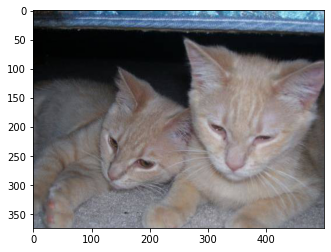

cat


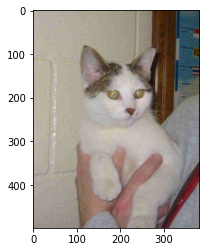

cat


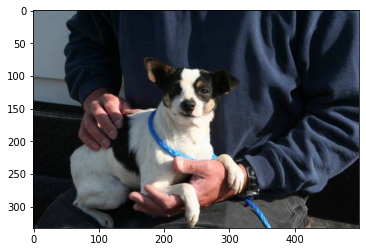

cat


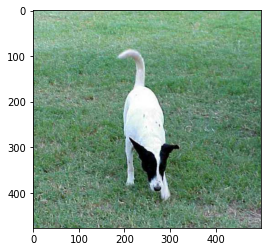

cat


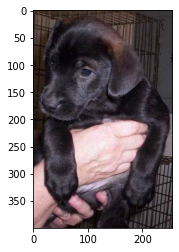

cat


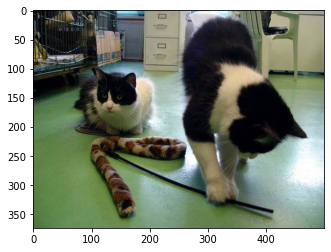

cat


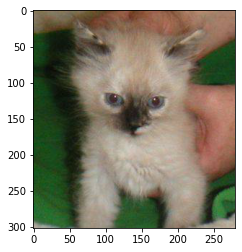

cat


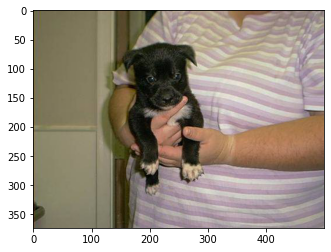

cat


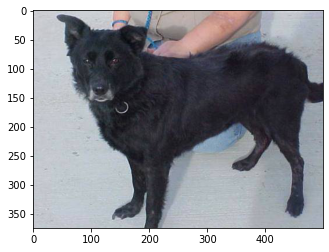

cat


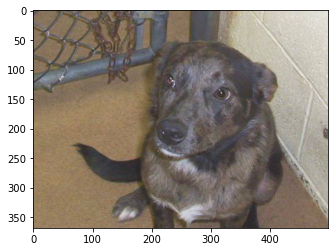

In [65]:
import pandas as pd
import os
import numpy as np



test_dataset = [i for i in os.listdir("./data/vgg16_dataset/test1") if i.endswith('jpg')]
df=pd.DataFrame({'id':[i for i in range(len(test_dataset))], 'label':[0 for i in range(len(test_dataset))]})

pd.options.mode.chained_assignment = None  # default='warn'

# 전체 테스트셋 중 30개만 분류
for e,i in enumerate(test_dataset[90:100]):
#     print(i)
    output=[]
    img = image.load_img(os.path.join("./data/vgg16_dataset/test1",i),target_size=(224,224))
    img = np.asarray(img)
    img = np.expand_dims(img, axis=0)
    output = model_1.predict(img)
    print(f"{output[0][0]} | {output[0][1]}")
#     print(output)
    if output[0][0] > output[0][1]:
#         print("cat")
        df["id"][e]=i
        df["label"][e]="cat"
    else:
#         print('dog')
        df["id"][e]=i
        df["label"][e]="dog"
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams["figure.figsize"] = (10,4)

for i in range(10):
    img = df.iloc[i]['id']
    label = df.iloc[i]['label'] 
    print(label)
    image_show = mpimg.imread(os.path.join('./data/vgg16_dataset/test1', img))
    plt.imshow(image_show)
    plt.show()
    

### ResNet50 -> Fine tuning

In [77]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Input, Activation,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,LambdaCallback
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [78]:
input = Input(shape=(224, 224, 3))

model = ResNet50(input_tensor=input, include_top=True, weights="imagenet", pooling='max')
print(model.summary())


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [79]:
x = model.output
x = Dense(1024, name='fully')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dense(2, activation='softmax', name='softmax')(x)
model_2 = Model(model.input, x)
model_2.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [80]:
for layers in (model_2.layers)[:-8]:
    print(layers)
    layers.trainable = False
    
X= model_2.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_2 = Model(model_2.input,predictions)
model_2.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

Total params: 27,193,706
Trainable params: 3,602,922
Non-trainable params: 23,590,784
__________________________________________________________________________________________________


In [81]:
train_datagen = ImageDataGenerator(rescale=1./255)#rgb값 reduce
train_generator = train_datagen.flow_from_directory(
        './data/vgg16_dataset/train_new',
        target_size=(224, 224),
        batch_size=30,
        class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        './data/vgg16_dataset/validation',
        target_size=(224, 224),
        batch_size=30,
        class_mode='categorical')

Found 23620 images belonging to 2 classes.
Found 4730 images belonging to 2 classes.


In [82]:
with tf.device('/gpu:0'):    
    model_2.compile(loss='categorical_crossentropy',
                      #optimizer=optimizers.RMSprop(lr=2e-4),
                      optimizer=Adam(),
                      metrics=['acc'])

#     print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: None)
    early_stopping = EarlyStopping(patience=15, mode='min', monitor='val_loss')
    history = model_2.fit_generator(train_generator,
                                  steps_per_epoch=10,
                                  epochs=100,
                                  validation_data=val_generator,
                                  validation_steps=5,
                                  callbacks=[early_stopping])

    #모델 평가
    print("-- Evaluate --")
    scores = model_2.evaluate_generator(val_generator, steps=5)
    print("%s: %.2f%%" %(model_2.metrics_names[1], scores[1]*100))

Epoch 1/100
10/10 [==============================] - 18s 2s/step - loss: 0.3705 - acc: 0.8733 - val_loss: 0.7011 - val_acc: 0.4533
Epoch 2/100
10/10 [==============================] - 2s 181ms/step - loss: 0.3236 - acc: 0.9133 - val_loss: 0.7041 - val_acc: 0.4533
Epoch 3/100
10/10 [==============================] - 2s 176ms/step - loss: 0.3638 - acc: 0.8967 - val_loss: 0.7076 - val_acc: 0.4533
Epoch 4/100
10/10 [==============================] - 2s 183ms/step - loss: 0.2470 - acc: 0.9200 - val_loss: 0.6992 - val_acc: 0.4533
Epoch 5/100
10/10 [==============================] - 2s 174ms/step - loss: 0.2126 - acc: 0.9333 - val_loss: 0.7008 - val_acc: 0.4533
Epoch 6/100
10/10 [==============================] - 2s 180ms/step - loss: 0.3498 - acc: 0.8900 - val_loss: 0.6893 - val_acc: 0.5467
Epoch 7/100
10/10 [==============================] - 2s 181ms/step - loss: 0.5371 - acc: 0.8267 - val_loss: 0.6919 - val_acc: 0.5467
Epoch 8/100
10/10 [==============================] - 2s 178ms/step - lo

In [83]:
model_2.save_weights("resnet50_2.h5")

0.6088849902153015 | 0.3911150097846985
0.6173581480979919 | 0.38264191150665283
0.3645998537540436 | 0.6354001760482788
0.3515685200691223 | 0.6484314799308777
0.38427239656448364 | 0.6157276034355164
0.6322352290153503 | 0.36776480078697205
0.6331613659858704 | 0.36683863401412964
0.5197768211364746 | 0.4802232086658478
0.36095356941223145 | 0.6390464305877686
0.36523741483688354 | 0.6347625851631165
cat


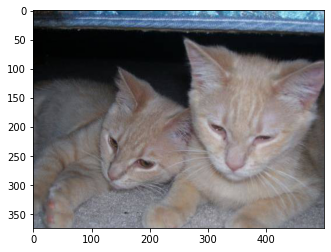

cat


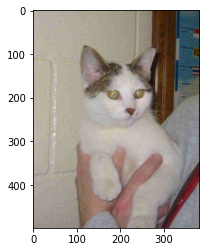

dog


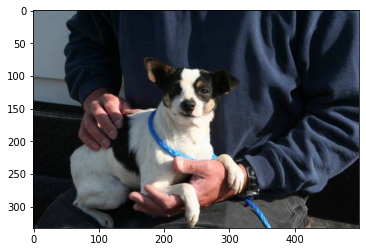

dog


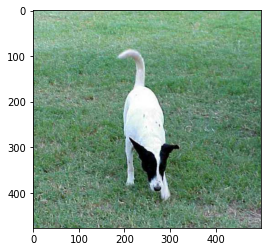

dog


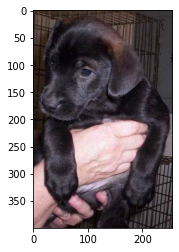

cat


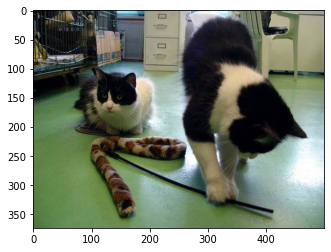

cat


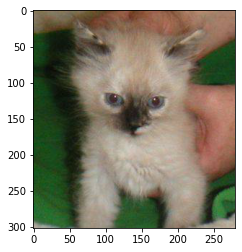

cat


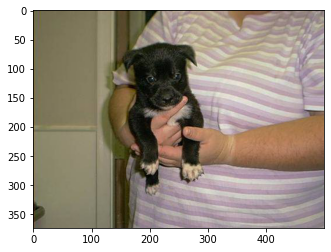

dog


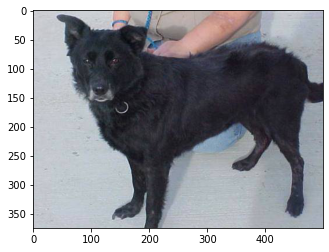

dog


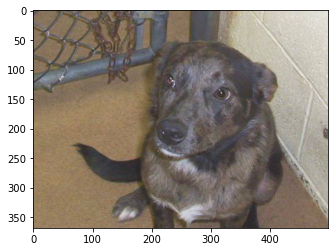

In [84]:
import pandas as pd
import os
import numpy as np



test_dataset = [i for i in os.listdir("./data/vgg16_dataset/test1") if i.endswith('jpg')]
df=pd.DataFrame({'id':[i for i in range(len(test_dataset))], 'label':[0 for i in range(len(test_dataset))]})

pd.options.mode.chained_assignment = None  # default='warn'

# 전체 테스트셋 중 30개만 분류
for e,i in enumerate(test_dataset[90:100]):
#     print(i)
    output=[]
    img = image.load_img(os.path.join("./data/vgg16_dataset/test1",i),target_size=(224,224))
    img = np.asarray(img)
    img = np.expand_dims(img, axis=0)
    output = model_2.predict(img)
    print(f"{output[0][0]} | {output[0][1]}")
#     print(output)
    if output[0][0] > output[0][1]:
#         print("cat")
        df["id"][e]=i
        df["label"][e]="cat"
    else:
#         print('dog')
        df["id"][e]=i
        df["label"][e]="dog"
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams["figure.figsize"] = (10,4)

for i in range(10):
    img = df.iloc[i]['id']
    label = df.iloc[i]['label'] 
    print(label)
    image_show = mpimg.imread(os.path.join('./data/vgg16_dataset/test1', img))
    plt.imshow(image_show)
    plt.show()
    

#### early stop 없이

In [13]:
with tf.device('/gpu:0'):    
    model_final.compile(loss='categorical_crossentropy',
                      #optimizer=optimizers.RMSprop(lr=2e-4),
                      optimizer=Adam(),
                      metrics=['acc'])

#     print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: None)
#     early_stopping = EarlyStopping(patience=15, mode='auto', monitor='val_loss')
    history = model_final.fit_generator(train_generator,
                                  steps_per_epoch=25,
                                  epochs=100,
                                  validation_data=val_generator,
                                  validation_steps=5)
#                                   callbacks=[early_stopping,print_weights])

    #모델 평가
    print("-- Evaluate --")
    scores = model_final.evaluate_generator(val_generator, steps=5)
    print("%s: %.2f%%" %(model_final.metrics_names[1], scores[1]*100))

Epoch 1/100
25/25 [==============================] - 8s 316ms/step - loss: 0.1515 - acc: 0.9520 - val_loss: 0.8188 - val_acc: 0.4933
Epoch 2/100
25/25 [==============================] - 3s 130ms/step - loss: 0.0938 - acc: 0.9693 - val_loss: 0.7983 - val_acc: 0.4933
Epoch 3/100
25/25 [==============================] - 3s 130ms/step - loss: 0.2046 - acc: 0.9387 - val_loss: 0.7495 - val_acc: 0.4933
Epoch 4/100
25/25 [==============================] - 3s 127ms/step - loss: 0.1325 - acc: 0.9533 - val_loss: 0.7297 - val_acc: 0.4933
Epoch 5/100
25/25 [==============================] - 3s 130ms/step - loss: 0.0764 - acc: 0.9653 - val_loss: 0.7041 - val_acc: 0.4933
Epoch 6/100
25/25 [==============================] - 3s 131ms/step - loss: 0.1283 - acc: 0.9640 - val_loss: 0.6986 - val_acc: 0.4933
Epoch 7/100
25/25 [==============================] - 3s 136ms/step - loss: 0.1435 - acc: 0.9493 - val_loss: 0.7059 - val_acc: 0.4933
Epoch 8/100
25/25 [==============================] - 3s 136ms/step - 

25/25 [==============================] - 3s 137ms/step - loss: 0.1137 - acc: 0.9693 - val_loss: 0.8113 - val_acc: 0.5067
Epoch 63/100
25/25 [==============================] - 3s 139ms/step - loss: 0.1010 - acc: 0.9787 - val_loss: 0.7417 - val_acc: 0.5067
Epoch 64/100
25/25 [==============================] - 4s 164ms/step - loss: 0.1136 - acc: 0.9627 - val_loss: 0.7332 - val_acc: 0.5067
Epoch 65/100
25/25 [==============================] - 3s 134ms/step - loss: 0.1072 - acc: 0.9613 - val_loss: 0.7094 - val_acc: 0.5067
Epoch 66/100
25/25 [==============================] - 3s 136ms/step - loss: 0.1240 - acc: 0.9600 - val_loss: 0.7147 - val_acc: 0.5067
Epoch 67/100
25/25 [==============================] - 3s 132ms/step - loss: 0.1109 - acc: 0.9707 - val_loss: 0.7028 - val_acc: 0.5067
Epoch 68/100
25/25 [==============================] - 3s 132ms/step - loss: 0.0692 - acc: 0.9827 - val_loss: 0.7182 - val_acc: 0.5067
Epoch 69/100
25/25 [==============================] - 3s 135ms/step - loss:

In [14]:
model_final.save_weights("resnet50_3.h5")

dog


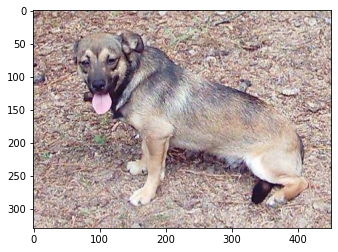

cat


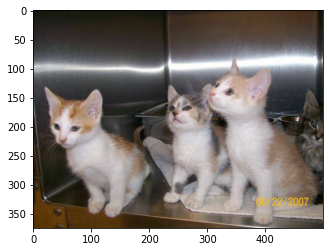

cat


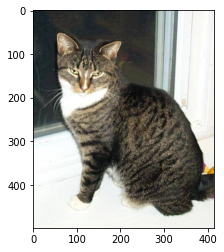

cat


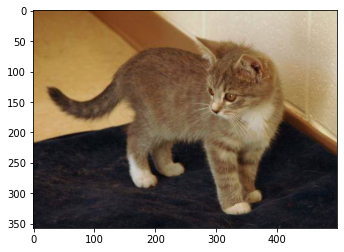

dog


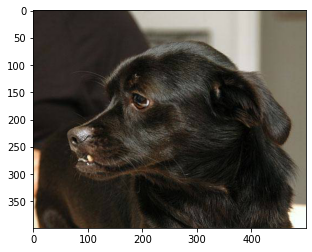

cat


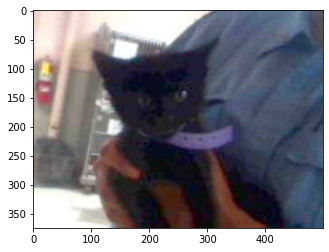

cat


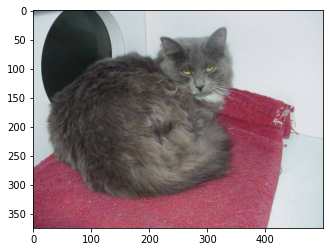

dog


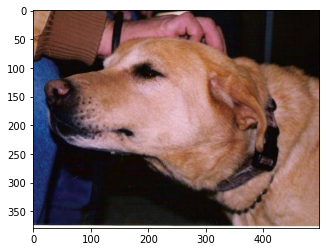

dog


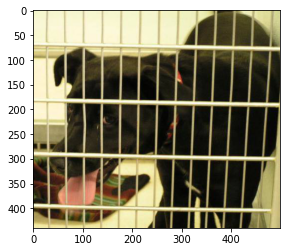

cat


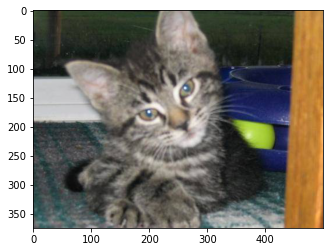

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
import numpy as np

test_dataset = os.listdir("./data/vgg16_dataset/test1")
df=pd.DataFrame({'id':[i for i in range(len(test_dataset))], 'label':[0 for i in range(len(test_dataset))]})

pd.options.mode.chained_assignment = None  # default='warn'

# 전체 테스트셋 중 30개만 분류
for e,i in enumerate(test_dataset[30:50]):
#     print(i)
    output=[]
    img = image.load_img(os.path.join("./data/vgg16_dataset/test1",i),target_size=(224,224))
    img = np.asarray(img)
    img = np.expand_dims(img, axis=0)
    output = model_final.predict(img)
#     print(output)
    if output[0][0] > output[0][1]:
#         print("cat")
        df["id"][e]=i
        df["label"][e]="cat"
    else:
#         print('dog')
        df["id"][e]=i
        df["label"][e]="dog"


for i in range(10):
    img = df.iloc[i]['id']
    label = df.iloc[i]['label'] 
    print(label)
    image_show = mpimg.imread(os.path.join('./data/vgg16_dataset/test1/', img))
    plt.imshow(image_show)
    plt.show()